## The purpose of this notebook is to test the performance of the anchor statistic in detecting deviation from population continuity. First I set up a simple demography with 2 populations in which an admixture event occurs occurs
## There are 2 branches in the simulated demography; popA & popB diverging 4000 gens ago.
## 4 samples are taken from popA: A1, A2, B & C. A1 is sampled at 1000, A2 varies between 100-900, B is sampled at 50 and C is sampled at 0 
## The admixture occurs from popB to popA at time 25. 
## 1 gen = 29 years, mu = 1.45e-8 and r=1.25e-8
## Here I am keeping the admixture proportion at 50% and varying the sampling time of the second anchor, A2.  

In [9]:
import msprime as msp
import random
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import scipy.stats as st
import math
import matplotlib as mpl
%matplotlib inline
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import allel; print('scikit-allel', allel.__version__)
from allel.stats.misc import jackknife
import sys

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


scikit-allel 1.3.5


## Global togle to save / not-save figures

In [10]:
isSaveFigures = True

# adjust some font params
plt.rcParams.update({'font.size': 14})
plt.rc('legend',fontsize='12')

In [11]:
# Ignore some warnings when calculating summary stats with missing data, typically on Tajima's D and Fst (division by zero, etc) 
np.seterr(invalid='ignore',divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Functions to downsample perfect simulated data and introduce aDNA damages

In [12]:
### MAKE EMPTY GENOTYPE ARRAY ····························································
def empty_genotype_array(n_loci, n_samples, ploidy=2, allele=-1):
    """
    Creates a genotype array with all values as missing (-1) for a given number
    of samples, loci and ploidy

    :return: empty_ga
    """
    empty_ga = allel.GenotypeArray(np.full((n_loci, n_samples, ploidy), allele, dtype='i1'), dtype='i1')
    return empty_ga
  
def test_empty_genotype_array():
    test_ga = empty_genotype_array(3, 4, ploidy=2, allele=-1)
    assert type(test_ga) is allel.model.ndarray.GenotypeArray
    assert len(test_ga) == 3
    assert all(test_ga[0,0] == [-1,-1])
    assert all(test_ga[2,3] == [-1,-1])
    test_ga = empty_genotype_array(3, 4, ploidy=2, allele=0)
    assert all(test_ga[1,1] == [0,0])
### end MAKE EMPTY GENOTYPE ARRAY ····························································


### SNP CALLING FROM SIMULATED READS (WITH SEQUENCING ERROR)  ····························
def snp_calling(true_genotype, f_num_reads, error_rate=0.005, reads_th=8, score_th=5, ratio_th=10, damage=False, transversion=True):
    """
    snp_calling function takes perfect simulated data from one locus of one 
    diploid individual and adds missing data and error according to the number 
    of reads of the site, error rate of the sequencing technology and, for 
    ancient DNA not sequenced from damage repair (dr) libraries, creates 
    missing data for transition SNPs (since they cannot be distinguished from
    aDNA damage)

    :param true_genotype:
    :param f_num_reads:
    :param error_rate:
    :param reads_th:
    :param score_th:
    :param ratio_th:
    :param dr:
    :param transversion:
    :return:
    """
    genotype_call = [-1, -1]
    if damage is True and transversion is False:
        genotype_call = [-1, -1]
    elif f_num_reads >= reads_th:
        derived_count = sum(true_genotype)
        p_derived = derived_count / 2. * (1 - error_rate) + (1 - derived_count / 2.) * error_rate
        derived_reads = st.binom.rvs(f_num_reads, p_derived)
        ancestral_reads = f_num_reads - derived_reads
        if f_num_reads >= (score_th*2):
            if derived_reads == 0:
                genotype_call = [0, 0]
            elif ancestral_reads == 0:
                genotype_call = [1, 1]
            else:
                if (derived_reads >= score_th) & (ancestral_reads < score_th):
                    genotype_call = [1, 1]
                elif (derived_reads < score_th) & (ancestral_reads >= score_th):
                    genotype_call = [0, 0]
                elif (derived_reads >= score_th) & (ancestral_reads >= score_th):
                    ratio_of_scores = derived_reads / ancestral_reads
                    if (ratio_of_scores >= 1 / ratio_th) & (ratio_of_scores <= ratio_th):
                        if (derived_count == 1):
                            genotype_call = true_genotype
                        elif (st.binom.rvs(1, 0.5) == 1):
                            genotype_call = [0, 1]
                        else:
                            genotype_call = [1, 0]
                    elif derived_reads > ancestral_reads:
                        genotype_call = [1, 1]
                    else:
                        genotype_call = [0, 0]
    else:
        genotype_call = [-1, -1]
    #print(genotype_call)
    return genotype_call

def test_snp_calling():
    np.random.seed(1234)
    genotype_call = snp_calling( [0, 1], 100, error_rate=0.005, reads_th=1,
                  score_th=10, ratio_th=3, damage=False, transversion=True)
    assert genotype_call == [0,1]
    genotype_call = snp_calling( [0, 1], 1, error_rate=0.005, reads_th=10,
                  score_th=10, ratio_th=3, damage=False, transversion=True)
    assert genotype_call == [-1,-1]
### end SNP CALLING FROM SIMULATED READS (WITH SEQUENCING ERROR)  ····························

### SIMULATE SEQUENCING  ····························
def sequencing(ts, ssize, ttr, seq_error, damage, cov):
    if len(cov) != ssize:
        msg = "Number of coverage values (length=" + str(len(cov)) + \
              ") and number of samples (ssize=" + str(ssize) + \
              ") do not match"
        raise ValueError(msg)

    geno_data = empty_genotype_array(n_loci=ts.num_sites,
                                   n_samples=ssize,
                                   ploidy=2)
    positions = []
    locus = 0
    for variant in ts.variants():
        positions.append(round(variant.position))
        #print(variant.position)
        var_genotypes = variant.genotypes
        #print("variant genotypes = ", var_genotypes)
        num_reads = np.random.poisson(lam=cov, size=ssize)
        #print("num_reads = ", num_reads)
        transversion_snp = True
        if np.random.random() < ttr / (ttr + 1):
            transversion_snp = False
        for i in range(0, 2 * ssize, 2):
            if len(variant.alleles)==2:
                gt_call = snp_calling(true_genotype = var_genotypes[i:(i + 2)],
                                      f_num_reads = num_reads[int(i / 2)],
                                      damage = damage[int(i / 2)],
                                      transversion = transversion_snp)
            else:
                gt_call = [-1, -1] # this removes all SNP with more than two alleles
            geno_data[locus, int(i / 2)] = gt_call
        locus = locus + 1
        #print(locus)
    return geno_data, positions

In [13]:
def get_anc_subset(full_arr, anchor):
    """ 
    Function to get subset of sites that are heterozygous in a given anchor individual
    """
    mask = full_arr[:,anchor-1,:].sum(axis=1)==1
    masked_arr = full_arr[mask,:,:]
    return masked_arr

def get_pseudo_prop(x_arr):  # function to get proportions of a pseudo-haploidized 1D array
    """
    Function to make a random choice for each site
    """
    pseudohap_arr = np.array([random.choice(i) for i in x_arr.tolist()])    
    out_val = np.true_divide(pseudohap_arr.sum(axis=0), pseudohap_arr.shape[0]).astype(float)
    return out_val

def get_prop_der(ind_arr, blen):
    """
    Function to return mean & SE for proportion derived of each individual 
    """
    # compute the prop der within each block and return mean across all (same as overall derived)
    b_prop_der = allel.moving_statistic(ind_arr, get_pseudo_prop, size=blen)
    m, se, vj = jackknife(b_prop_der, statistic=np.mean)
    return m, se

def get_prop_win(ind_arr, blen):
    """
    Get proportion derived for windows of given length.
    Returns array, rather than mean of the array, as "get_prop_der"
    """
    b_prop_der = allel.moving_statistic(ind_arr, get_pseudo_prop, size=blen)
    return b_prop_der

def get_gammas(x_arr):   # input is 3D array of shape(n-1,4,2)
    """
    Function to estimate proportion of admixture
    """
    mean_prop_der = np.mean(x_arr, axis=0) # get mean prop der across all wins, returns array of shape(4=Inds,2=PropDerAnc4&3)
    AncA1_C = mean_prop_der[0,0]
    AncA1_B = mean_prop_der[1,0]
    AncA2_C = mean_prop_der[0,1]
    AncA2_B = mean_prop_der[1,1]
    AncA2_A1 = mean_prop_der[3,1]
    gamma = 1 - (((AncA1_B*AncA2_C) - (AncA1_C*AncA2_A1)) / ((AncA1_B*AncA2_B) - (AncA1_B*AncA2_A1)))
    return gamma

def jackknife_est(x,func):
    """
    Function to get jackknife estimate of the admixture estimator, also returns variance and SEM
    """
    n = len(x)
    idx = np.arange(n)
    j_est = np.sum(func(x[idx!=i]) for i in range(n))/float(n)
    j_var = (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0 for i in range(n))
    j_SEM = math.sqrt(j_var)
    return j_est, j_var, j_SEM

# msprime simulations

First use msprime to generate data under two simple topologies. Idea here is to demonstrate that alternative demographies can give rise to qualitatively similar patterns of genetic variation and summary statistics (PCA). 
This run, recombination rate = 1.25 e-8, mutation rate = 1.45 e-8, generation time = 29 years. 7 samples are taken from 2 populations at 2 different time points (modern and ancient).

In [14]:
# fixed parameters
gen_time = 29
L = 2000000
mu = 1.45e-8 # equates to 0.5e-9/yr
r = 1.25e-8

In [15]:
# create empty array to take gamma values and standard errors
gamma_arr = np.zeros(30).reshape(10,3).astype(float)

# Demographic model

### Fixed splits, admixture dates and fractions:

In [16]:
t_AB_split = 4000

# Population sizes
popA_N = 10000  
popB_N = 10000
popAB_N = 10000
admix_t, admix_frac = 25, 0.5

In [17]:
numRuns=1000 # the number of independent simulations to run for a given demography

In [18]:
for idx, samplingA2 in enumerate(range(100,1100,100)): # iterate simulations across range of A2 sampling times
    # build msprime demographies
    demography = msp.Demography()
    demography.add_population(name="PA", initial_size=popA_N, default_sampling_time=0)
    demography.add_population(name="PB", initial_size=popB_N, default_sampling_time=0)
    demography.add_population(name="PAB", initial_size=popB_N, default_sampling_time=t_AB_split)
    demography.add_population_split(time=t_AB_split, derived=['PA','PB'], ancestral='PAB') # add the fixed split to msprime's demography
    demography.add_mass_migration(time=admix_t, source='PA', dest='PB', proportion=admix_frac) # equivalent to PB to PA forwards in time
    demography.sort_events()
    
    # choose samples to take from demographic objects
    def set_up_samples(tS):
        samples = [msp.SampleSet(num_samples=1, population=0, time=tS[0], ploidy=2)] # Sample C
        samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[1], ploidy=2)]) # Sample B
        samples.extend([msp.SampleSet(num_samples=1, population=0, time=samplingA2, ploidy=2)]) # Sample A2
        samples.extend([msp.SampleSet(num_samples=1, population=0, time=tS[3], ploidy=2)]) # Sample A1
        return samples
    tS=[0,50,100,1000] # specify sampling times
    Samples = set_up_samples(tS)   
    
    for aRun in range(numRuns):
        ts = msp.sim_ancestry(
            samples = Samples,
            demography=demography,
            recombination_rate=r,
            sequence_length=L,
            model=[msp.DiscreteTimeWrightFisher(duration=50), msp.StandardCoalescent()],
            random_seed=None
        )
        # This generates an ancestral history for samples. If we want genome sequence we must also simulate mutations on these trees. 
        # Note I am running Discrete Time Wright Fisher model for time=50. This is to better model long-range LD when simulating long sequences. This
        # is only an issue in recent past, and then I revert to standard coalescent model. Slows simulations, but may remove spurious high LD.
        # Given an input tree sequence, superimpose mutations on that ancestral history.  
        mut_treesq = msp.sim_mutations(ts, rate=mu, random_seed=None)
    
        # pipe perfect simulation results through functions to add errors and make comparable to empirical data
        chrono_order_is_damaged = np.repeat(np.array([True,False], dtype=bool), [0,4])
        covs = np.array([50.0]) # coverages of all samples (moderns from SGDP)
        repeats = np.array([4])
        chrono_order_coverage = np.repeat(covs, repeats)

        geno_data, positions = sequencing(ts = mut_treesq,
                                          ssize = 4,
                                          ttr = 2.1,
                                          seq_error = 0.005,
                                          damage = chrono_order_is_damaged,
                                          cov = chrono_order_coverage)

        # Export the genotype data to allel. Unfortunately there's a slight mismatch in the terminology here where genotypes and haplotypes mean different things in the two libraries.
        if aRun == 0:
            geno_arr = geno_data
            pos_list = positions
        else:
            geno_arr = np.concatenate((geno_arr,geno_data),axis=0) # stack arrays row-wise
            pos_list.extend(x+(aRun*L) for x in positions) # keep adding current length of simulated sequence to positions
    geno_arr = allel.GenotypeArray(geno_arr, dtype='i1')
        
    # get the subset array of het sites for a specified anchor 
    anchorA1_mat1 = get_anc_subset(geno_arr,4) # the last sample is the oldest
    anchorA2_mat1 = get_anc_subset(geno_arr,3)  

    # get proportion derived in all individuals for each anchor
    propder_anchorA1_mat1 = np.array([(get_prop_der(x, 1000)) for x in anchorA1_mat1.transpose(1, 0, 2)])
    propder_anchorA2_mat1 = np.array([(get_prop_der(x, 1000)) for x in anchorA2_mat1.transpose(1, 0, 2)])
            
    # save resulting proportions derived to file
    A2T = int(samplingA2)
    np.savetxt('Prop_Der_AnchorA1_A2T_{}.txt'.format(A2T), propder_anchorA1_mat1)
    np.savetxt('Prop_Der_AnchorA2_A2T_{}.txt'.format(A2T), propder_anchorA2_mat1)
        
    # Get arrays of proportions derived across 10000 SNP windows with Anchor=Ind6 and Anchor=Ind4
    windowed_propder_anchorA1 = np.array([(get_prop_win(x, 1000)) for x in anchorA1_mat1.transpose(1, 0, 2)])   
    windowed_propder_anchorA2 = np.array([(get_prop_win(x, 1000)) for x in anchorA2_mat1.transpose(1, 0, 2)])
    windowed_propder_anchorA1_trans = np.transpose(windowed_propder_anchorA1, (1,0)).reshape(windowed_propder_anchorA1.shape[1],4,1)    # transpose to (nwindows,4) and reshape to (#wins,4,1)
    windowed_propder_anchorA2_trans = np.transpose(windowed_propder_anchorA2, (1,0)).reshape(windowed_propder_anchorA2.shape[1],4,1) 

    # combine into single 3D array of length n (= len(min) of both arrays). Final dimension contains 2 columns for propderA1 & propderA2
    if len(windowed_propder_anchorA1_trans) == len(windowed_propder_anchorA2_trans):
        combined_arr = np.append(windowed_propder_anchorA1_trans, windowed_propder_anchorA2_trans, axis=2)
    elif len(windowed_propder_anchorA1_trans) > len(windowed_propder_anchorA2_trans):
        combined_arr = np.append(windowed_propder_anchorA1_trans[0:len(windowed_propder_anchorA2_trans),:,:], windowed_propder_anchorA2_trans, axis=2)
    else:
        combined_arr = np.append(windowed_propder_anchorA1_trans, windowed_propder_anchorA2_trans[0:len(windowed_propder_anchorA1_trans),:,:], axis=2)
    
    gamma_arr[idx,:] = jackknife_est(combined_arr, get_gammas) # get jackknifed estimate of admixture. Add to this admixture fraction      

/tmp/ipykernel_17619/475625440.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  j_est = np.sum(func(x[idx!=i]) for i in range(n))/float(n)
/tmp/ipykernel_17619/475625440.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  j_var = (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0 for i in range(n))


In [19]:
np.savetxt('gamma_estimates_A2T.txt', gamma_arr) # save down admixture estimate array

In [23]:
gamma_arr

array([[4.83324613e-01, 5.87861077e-03, 7.66720990e-02],
       [5.26260216e-01, 5.98433720e-03, 7.73584979e-02],
       [4.99501899e-01, 6.70641752e-03, 8.18927196e-02],
       [4.59936275e-01, 1.01617771e-02, 1.00805640e-01],
       [5.15685651e-01, 1.62828384e-02, 1.27604226e-01],
       [6.52784268e-01, 2.17682041e-02, 1.47540517e-01],
       [3.89248269e-01, 3.77815111e-02, 1.94374667e-01],
       [3.09324418e-01, 6.36298709e-02, 2.52249620e-01],
       [8.37739732e-01, 2.35277174e-01, 4.85053785e-01],
       [7.64132059e+00, 4.51241126e+03, 6.71744837e+01]])

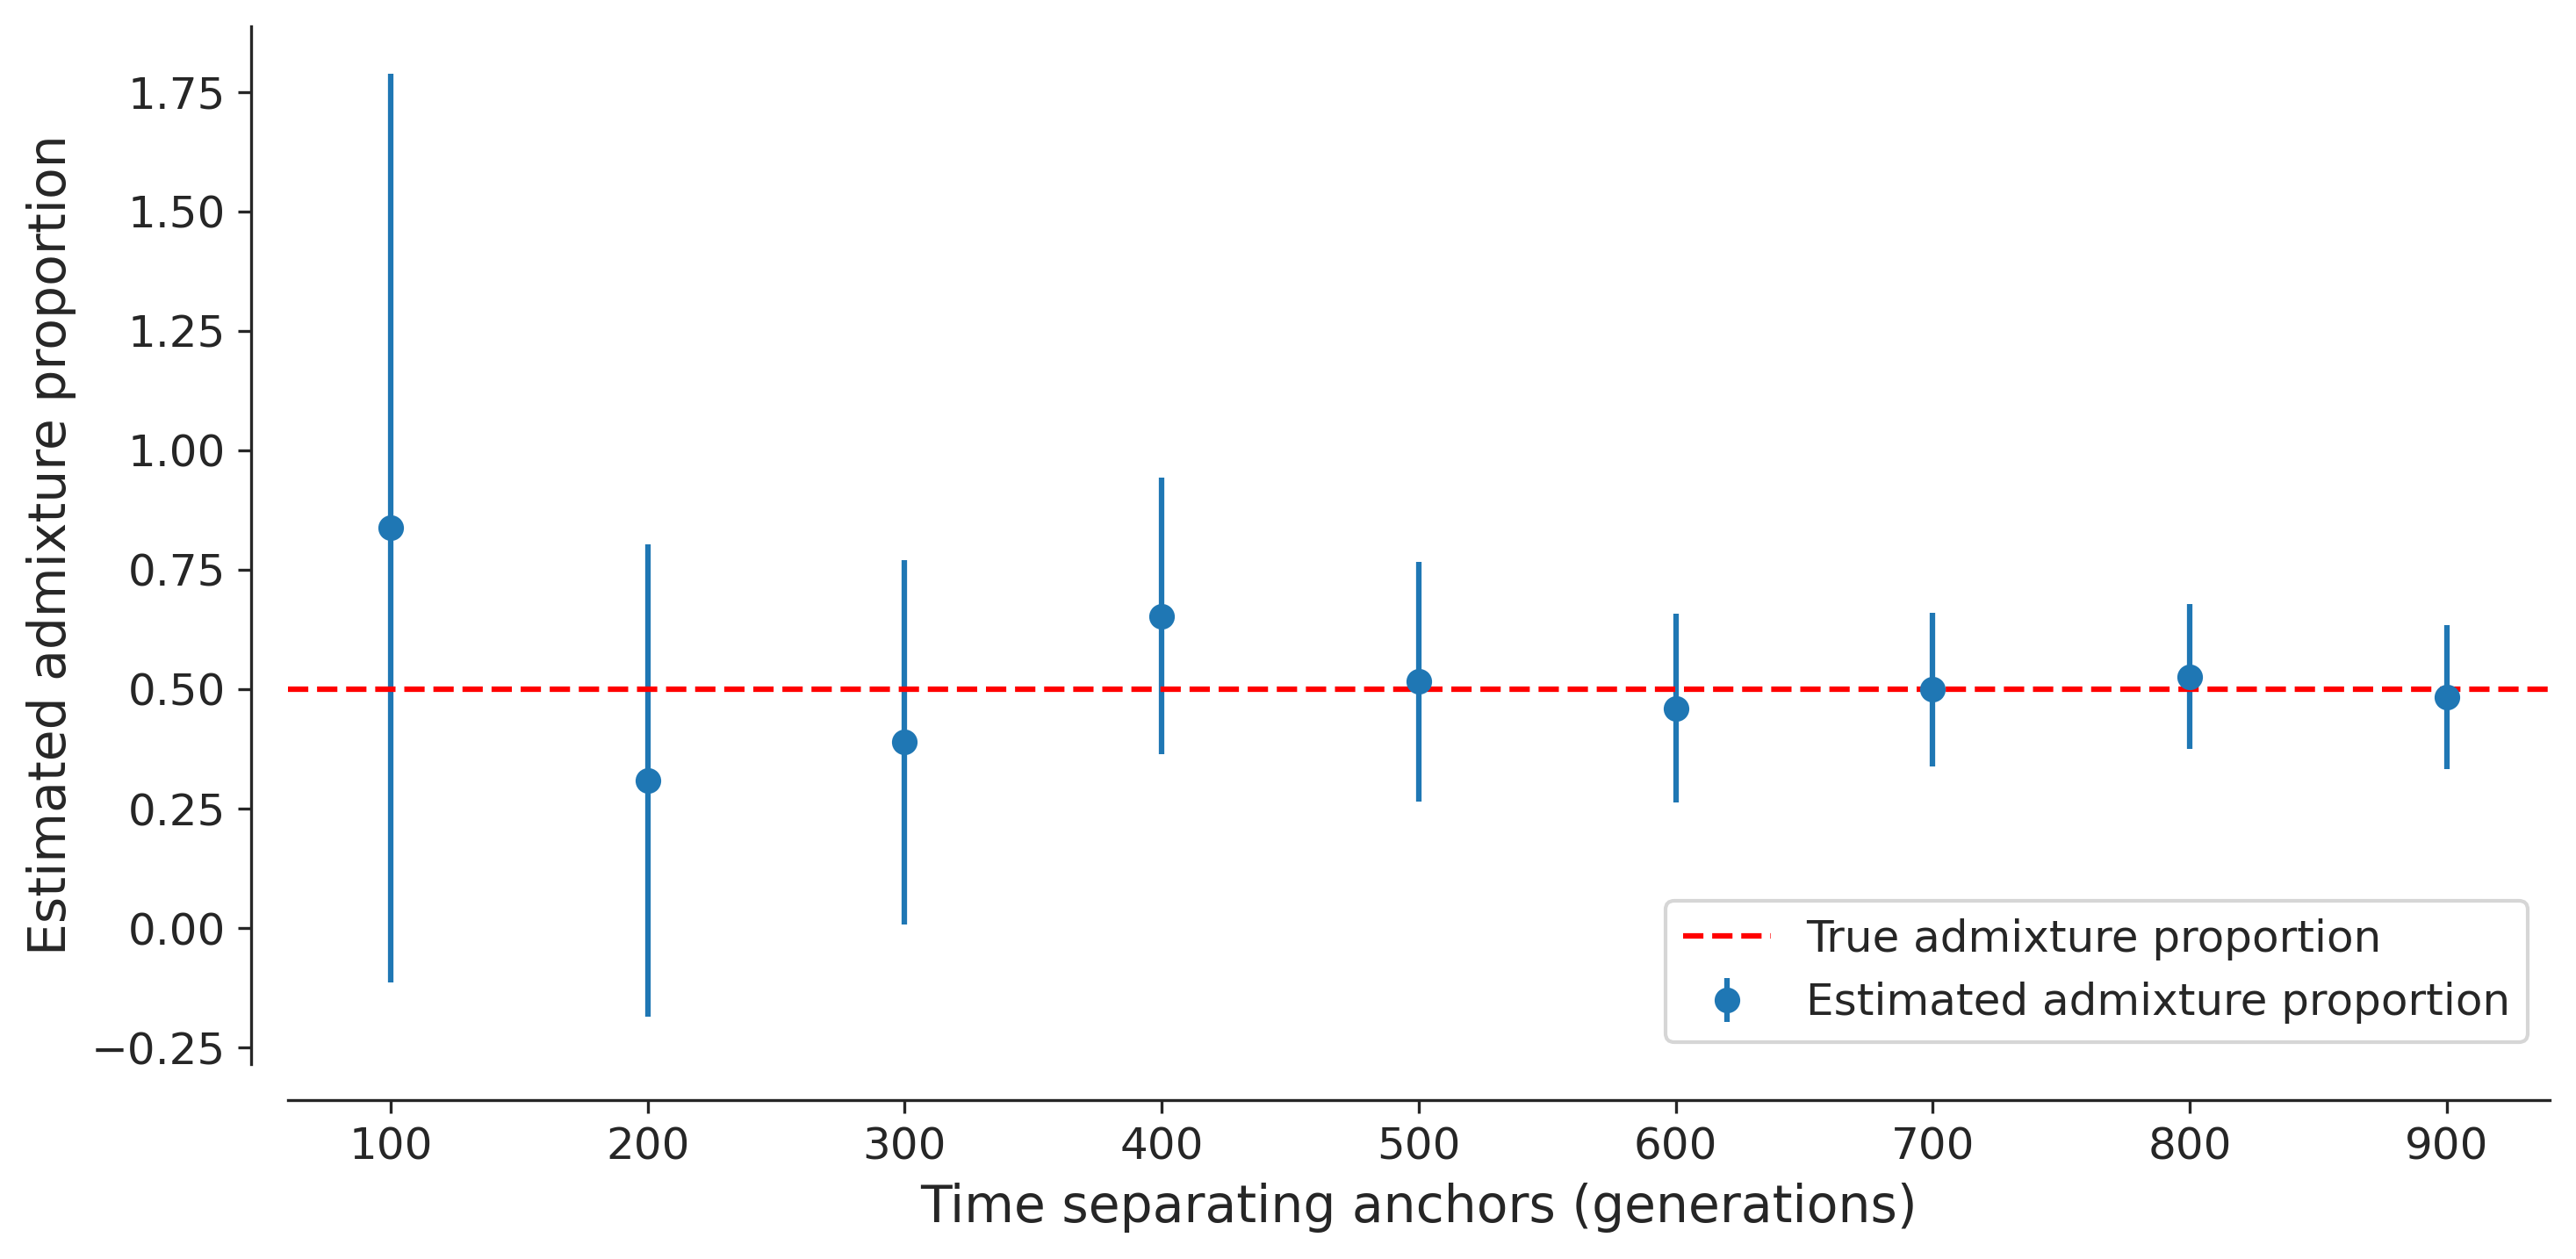

In [28]:
# plot gamma array
def plot_gammas(y_array, samples, title=None):
    x = samples[0:-1]
    y = y_array[0:-1,0]
    sterr = 1.96*y_array[0:-1,2]
    rho = st.pearsonr(y,x)[0]
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    sns.despine(ax=ax, offset=10)
    ax.errorbar(x, y, yerr=sterr, marker='o', linestyle = 'None', label="Estimated admixture proportion")
    ax.axhline(y=0.5, color='r', linestyle='--', label="True admixture proportion")
    #ax.plot([], [], ' ', label="Correlation coefficient = {}".format(np.round(rho,2)))
    ax.set_xlabel('Time separating anchors (generations)')
    ax.set_ylabel('Estimated admixture proportion')
#    ax.set(xlim=(1000, 6000))
    ax.legend(loc=4)
    if title:
        ax.set_title(title, loc='left', fontsize=20)
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(14)   
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)  
    fig.tight_layout()    

Samples = 1000-np.arange(100,1100,100) # time separating the two anchors
plot_gammas(gamma_arr, Samples)
if isSaveFigures:
    plt.savefig('Figures/Admix_estimates_A2T.pdf', bbox_inches='tight')

In [22]:
# For scikit allel reference: Miles A, Harding N (2017) scikit-allel.  https://doi.org/10.5281/zenodo.822784